# Predikcia vsetkych parametrov pomocou jednej NN
## Normovane overcontact data

In [1]:
# LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


In [2]:
from keras.utils import np_utils
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Dropout, Flatten
from keras.models import Model
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
np.random.seed(1234)
pd.set_option('display.max_rows', None)

In [4]:
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

## Data loading

In [3]:
data = pd.read_pickle("overcontact_all_parameters.pkl").reset_index()

In [4]:
data.head(15)

,index,id,curve,primary__t_eff,secondary__t_eff,inclination,mass_ratio,primary__surface_potential,secondary__surface_potential,t1/t2,filter,critical_surface_potential,primary__equivalent_radius,secondary__equivalent_radius,primary__filling_factor,secondary__filling_factor
0,0,5525038,"[0.9271109336686163, 0.9271335908185164, 0.927...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_U,1.959104,0.585781,0.21126,0.169244,0.169244
1,1,5525038,"[0.9267426667358384, 0.9267640025030627, 0.926...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_B,1.959104,0.585781,0.21126,0.169244,0.169244
2,2,5525038,"[0.9271736551553694, 0.927193188167849, 0.9272...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_V,1.959104,0.585781,0.21126,0.169244,0.169244
3,3,5525038,"[0.9286697051715368, 0.9286879105609007, 0.928...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_R,1.959104,0.585781,0.21126,0.169244,0.169244
4,4,5525038,"[0.9304596200748534, 0.9304764401089076, 0.930...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_I,1.959104,0.585781,0.21126,0.169244,0.169244
5,5,5525038,"[0.9263605918886462, 0.9263835804130542, 0.926...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,SLOAN_u,1.959104,0.585781,0.21126,0.169244,0.169244
6,6,5525038,"[0.9266103202592234, 0.9266310232075831, 0.926...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,SLOAN_g,1.959104,0.585781,0.21126,0.169244,0.169244
7,7,5525038,"[0.9284075655971418, 0.9284260371820944, 0.928...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,SLOAN_r,1.959104,0.585781,0.21126,0.169244,0.169244
8,8,5525038,"[0.9298295407058014, 0.9298467162820484, 0.929...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,SLOAN_i,1.959104,0.585781,0.21126,0.169244,0.169244
9,9,5525038,"[0.9311504581610326, 0.9311666682272106, 0.931...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,SLOAN_z,1.959104,0.585781,0.21126,0.169244,0.169244


In [7]:
data_sample = data.sample(n=100000)

In [8]:
list(data_sample.columns)

['index',
 'id',
 'curve',
 'primary__t_eff',
 'secondary__t_eff',
 'inclination',
 'mass_ratio',
 'primary__surface_potential',
 'secondary__surface_potential',
 't1/t2',
 'filter',
 'critical_surface_potential',
 'primary__equivalent_radius',
 'secondary__equivalent_radius',
 'primary__filling_factor',
 'secondary__filling_factor']

## Train test split

In [9]:
X = []
for row in data_sample["curve"]:
    X.append(row)
X=np.array(X)

In [10]:
y = np.array(data_sample[[
    "primary__t_eff",
    "secondary__t_eff",
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1/t2",
    "critical_surface_potential",
    "primary__equivalent_radius",
    "secondary__equivalent_radius",
    "primary__filling_factor",
    "secondary__filling_factor"]])

In [11]:
y[0]

array([7.25000000e+03, 7.25000000e+03, 1.34646754e+00, 5.00000000e+00,
       8.84280105e+00, 8.84280105e+00, 1.00000000e+00, 9.16363872e+00,
       2.76515706e-01, 5.46146250e-01, 5.02919516e-01, 5.02919516e-01])

In [12]:
# MinMax Scaler
scaler = MinMaxScaler()
y_minmax_scaled = scaler.fit_transform(y)
y_minmax_scaled[0]

array([0.8       , 0.8       , 0.79148929, 0.49494949, 0.53031622,
       0.53031622, 0.        , 0.54862702, 0.1671155 , 0.85762583,
       0.48776465, 0.48776465])

In [13]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y_minmax_scaled, test_size=0.2)

In [14]:
# Adding noise to data
X_train_n = []
y_train_n = []
for i in range(len(X_train1)):
    for j in range(3):
        curve = stochastic_noise_generator(X_train1[i])
        X_train_n.append(curve[0])
        y_train_n.append(y_train1[i])
X_train_n = np.array(X_train_n)
y_train_n=np.array(y_train_n)

In [15]:
print("Number of records in dataset: ", len(data),
    "\nNumber of records in sample: ", len(X),
    "\nNumber of train data without noise: ", len(X_train1),
    "\nNumber of train data with noise: ", len(X_train_n),
    "\nNumber of test data without noise: ", len(X_test))

Number of records in dataset:  1212796 
Number of records in sample:  100000 
Number of train data without noise:  80000 
Number of train data with noise:  240000 
Number of test data without noise:  20000


## Model

In [16]:
inputs = Input(shape=(400, 1))
b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(12, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 199, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 199, 64)           33024     
_________________________________________________________________
flatten (Flatten)            (None, 12736)             0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [17]:
saved_model = "models/norm_overcontact_all_params.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [18]:
history = model.fit(X_train_n, y_train_n, validation_split = 0.1, epochs = 10, verbose = 1, callbacks = callbacks_list, batch_size = 64)

Epoch 1/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.1177 - mape: 6007802.0000
Epoch 00001: val_mae improved from inf to 0.08945, saving model to models\norm_overcontact_all_params.hdf5
3375/3375 [==============================] - 398s 118ms/step - loss: 0.0285 - mae: 0.1177 - mape: 6007802.0000 - val_loss: 0.0182 - val_mae: 0.0894 - val_mape: 4261444.0000
Epoch 2/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0181 - mae: 0.0895 - mape: 3811119.0000
Epoch 00002: val_mae improved from 0.08945 to 0.08291, saving model to models\norm_overcontact_all_params.hdf5
3375/3375 [==============================] - 403s 120ms/step - loss: 0.0181 - mae: 0.0895 - mape: 3811119.0000 - val_loss: 0.0160 - val_mae: 0.0829 - val_mape: 3664032.7500
Epoch 3/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0167 - mae: 0.0841 - mape: 3351118.7500
Epoch 00003: val_mae improved from 0.08291 to 0.07869, saving model to models\norm_overcontact

In [15]:
model = load_model("models/norm_overcontact_all_params.hdf5")

## Model evaluation on normalized test data

In [20]:
# Evaluated on normalized test data without noise
model.evaluate(X_test, y_test)

625/625 [==============================] - 16s 26ms/step - loss: 0.0123 - mean_absolute_error: 0.0656 - mean_absolute_percentage_error: 2601702.5000


[0.012263502925634384, 0.06563691049814224, 2601702.5]

In [16]:
# Adding noise to normalized test data
X_test_n = []
y_test_norm_n = []
for i in range(len(X_test)):
    for j in range(3):
        curve = stochastic_noise_generator(X_test[i])
        X_test_n.append(curve[0])
        y_test_norm_n.append(y_test[i])
        j += 1
X_test_n = np.array(X_test_n)
y_test_norm_n = np.array(y_test_norm_n)

In [22]:
# Evaluated on normalized test data with noise
model.evaluate(X_test_n, y_test_norm_n)

1875/1875 [==============================] - 53s 28ms/step - loss: 0.0126 - mean_absolute_error: 0.0674 - mean_absolute_percentage_error: 2633009.0000


[0.012629610486328602, 0.06740511208772659, 2633009.0]

## Prediction on normalized test data without noise

In [17]:
y_pred_norm = model.predict(X_test)

In [24]:
y_pred_norm = pd.DataFrame(y_pred_norm,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [25]:
y_pred_norm.head()

,P_prim__t_eff,P_sec__t_eff,P_inclination,P_mass_ratio,P_prim__surface_potential,P_sec__surface_potential,P_t1_t2,P_critical_surface_potential,P_primary_equivalent_radius,P_secondary_equivalent_radius,P_primary_filling_factor,P_secondary_filling_factor
0,0.730700,0.641435,0.418716,0.384161,0.427710,0.430230,0.460207,0.440597,0.191341,0.765806,0.272192,0.275702
1,0.667254,0.633096,0.390487,0.363345,0.400840,0.404148,0.217769,0.423934,0.244005,0.819013,0.544745,0.549805
2,0.692350,0.600165,0.954842,0.101898,0.143007,0.143730,0.483797,0.150604,0.474684,0.523478,0.271666,0.278474
3,0.444795,0.352019,0.390645,0.122570,0.148317,0.152459,0.573356,0.176278,0.547256,0.674422,0.715392,0.718190
4,0.661633,0.592489,0.930711,-0.005371,0.014926,0.030138,0.382895,0.009393,0.788275,0.067036,0.227907,0.212224


In [26]:
pred_mean = y_pred_norm.mean(axis=0)
pred_mean

P_prim__t_eff                    0.581497
P_sec__t_eff                     0.506449
P_inclination                    0.683124
P_mass_ratio                     0.131902
P_prim__surface_potential        0.157280
P_sec__surface_potential         0.160340
P_t1_t2                          0.408443
P_critical_surface_potential     0.179674
P_primary_equivalent_radius      0.553582
P_secondary_equivalent_radius    0.616754
P_primary_filling_factor         0.620432
P_secondary_filling_factor       0.619194
dtype: float32

In [27]:
y_test_norm = pd.DataFrame(y_test,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [28]:
true_mean = y_test_norm.mean(axis=0)
true_mean

P_prim__t_eff                    0.611300
P_sec__t_eff                     0.533917
P_inclination                    0.675192
P_mass_ratio                     0.132607
P_prim__surface_potential        0.157641
P_sec__surface_potential         0.157641
P_t1_t2                          0.408646
P_critical_surface_potential     0.177235
P_primary_equivalent_radius      0.563542
P_secondary_equivalent_radius    0.603618
P_primary_filling_factor         0.603738
P_secondary_filling_factor       0.603738
dtype: float64

In [29]:
eval_pred = pd.DataFrame({'attribute': true_mean.index,
            'avg_true': true_mean.values,
            'avg_pred': pred_mean.values,
            'abs_error_%': 100*(abs(true_mean.values - pred_mean.values))})

In [30]:
eval_pred

,attribute,avg_true,avg_pred,abs_error_%
0,P_prim__t_eff,0.611300,0.581497,2.980269
1,P_sec__t_eff,0.533917,0.506449,2.746804
2,P_inclination,0.675192,0.683124,0.793200
3,P_mass_ratio,0.132607,0.131902,0.070580
4,P_prim__surface_potential,0.157641,0.157280,0.036081
5,P_sec__surface_potential,0.157641,0.160340,0.269937
6,P_t1_t2,0.408646,0.408443,0.020319
7,P_critical_surface_potential,0.177235,0.179674,0.243842
8,P_primary_equivalent_radius,0.563542,0.553582,0.995973
9,P_secondary_equivalent_radius,0.603618,0.616754,1.313543


Text(0, 0.5, 'Avg')

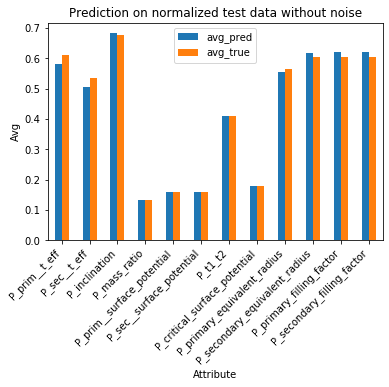

In [31]:
x = np.arange(len(eval_pred))
eval_pred[["avg_pred", "avg_true"]].plot(kind="bar")
plt.title("Prediction on normalized test data without noise")
plt.xlabel("Attribute")
plt.xticks(x, eval_pred.attribute, rotation=45, ha='right')
plt.ylabel("Avg")

### Denormalization

In [18]:
denormalized = scaler.inverse_transform(y_pred_norm)
denorm_pred = pd.DataFrame(denormalized,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])
pred_mean = denorm_pred.mean(axis=0)
pred_mean

P_prim__t_eff                    6430.596191
P_sec__t_eff                     6149.156250
P_inclination                       1.229885
P_mass_ratio                        1.405825
P_prim__surface_potential           3.968041
P_sec__surface_potential            4.008068
P_t1_t2                             1.048048
P_critical_surface_potential        4.318586
P_primary_equivalent_radius         0.427423
P_secondary_equivalent_radius       0.452089
P_primary_filling_factor            0.631660
P_secondary_filling_factor          0.630456
dtype: float32

In [19]:
y_test_df = pd.DataFrame(y,
                        columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])
test_mean = y_test_df.mean(axis=0)
test_mean

P_prim__t_eff                    6539.230000
P_sec__t_eff                     6248.500000
P_inclination                       1.221962
P_mass_ratio                        1.420276
P_prim__surface_potential           3.984510
P_sec__surface_potential            3.984510
P_t1_t2                             1.048238
P_critical_surface_potential        4.296444
P_primary_equivalent_radius         0.430659
P_secondary_equivalent_radius       0.446779
P_primary_filling_factor            0.612134
P_secondary_filling_factor          0.612134
dtype: float64

In [20]:
eval_pred = pd.DataFrame({'attribute': test_mean.index,
            'avg_true': test_mean.values,
            'avg_pred': pred_mean.values,
            'MAE': abs(test_mean.values - pred_mean.values)})
eval_pred

,attribute,avg_true,avg_pred,MAE
0,P_prim__t_eff,6539.230000,6430.596191,108.633809
1,P_sec__t_eff,6248.500000,6149.156250,99.343750
2,P_inclination,1.221962,1.229885,0.007922
3,P_mass_ratio,1.420276,1.405825,0.014452
4,P_prim__surface_potential,3.984510,3.968041,0.016468
5,P_sec__surface_potential,3.984510,4.008068,0.023558
6,P_t1_t2,1.048238,1.048048,0.000190
7,P_critical_surface_potential,4.296444,4.318586,0.022142
8,P_primary_equivalent_radius,0.430659,0.427423,0.003236
9,P_secondary_equivalent_radius,0.446779,0.452089,0.005311


## Prediction on normalized test data with noise

In [21]:
y_pred_norm_n = model.predict(X_test_n)

In [22]:
y_pred_norm_n_df = pd.DataFrame(y_pred_norm_n,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [23]:
y_pred_norm_n_df.head()

,P_prim__t_eff,P_sec__t_eff,P_inclination,P_mass_ratio,P_prim__surface_potential,P_sec__surface_potential,P_t1_t2,P_critical_surface_potential,P_primary_equivalent_radius,P_secondary_equivalent_radius,P_primary_filling_factor,P_secondary_filling_factor
0,0.731108,0.642069,0.418965,0.385693,0.429225,0.431699,0.459021,0.442174,0.189978,0.767487,0.273788,0.277410
1,0.695474,0.591175,0.455435,0.564000,0.591116,0.590269,0.434000,0.601093,0.135302,0.789251,0.258360,0.264035
2,0.730905,0.641577,0.418952,0.383237,0.426770,0.429259,0.460711,0.439604,0.192433,0.764712,0.271583,0.275146
3,0.609244,0.577377,0.427257,0.408889,0.444473,0.451452,0.226618,0.467438,0.217026,0.825904,0.535097,0.535334
4,0.665286,0.631790,0.399950,0.362256,0.400224,0.403743,0.216253,0.422351,0.241592,0.809153,0.520361,0.525479


In [24]:
n_pred_mean = y_pred_norm_n_df.mean(axis=0)
n_pred_mean

P_prim__t_eff                    0.580869
P_sec__t_eff                     0.505880
P_inclination                    0.683618
P_mass_ratio                     0.132223
P_prim__surface_potential        0.157623
P_sec__surface_potential         0.160710
P_t1_t2                          0.408284
P_critical_surface_potential     0.179985
P_primary_equivalent_radius      0.553181
P_secondary_equivalent_radius    0.616434
P_primary_filling_factor         0.619681
P_secondary_filling_factor       0.618427
dtype: float32

In [25]:
y_test_norm_n_df = pd.DataFrame(y_test_norm_n,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [26]:
n_true_mean = y_test_norm_n_df.mean(axis=0)
n_true_mean

P_prim__t_eff                    0.611300
P_sec__t_eff                     0.533917
P_inclination                    0.675192
P_mass_ratio                     0.132607
P_prim__surface_potential        0.157641
P_sec__surface_potential         0.157641
P_t1_t2                          0.408646
P_critical_surface_potential     0.177235
P_primary_equivalent_radius      0.563542
P_secondary_equivalent_radius    0.603618
P_primary_filling_factor         0.603738
P_secondary_filling_factor       0.603738
dtype: float64

In [27]:
n_eval_pred = pd.DataFrame({'attribute': n_true_mean.index,
            'avg_true': n_true_mean.values,
            'avg_pred': n_pred_mean.values,
            'abs_error_%': 100*(abs(n_true_mean.values - n_pred_mean.values))})
n_eval_pred

,attribute,avg_true,avg_pred,abs_error_%
0,P_prim__t_eff,0.611300,0.580869,3.043092
1,P_sec__t_eff,0.533917,0.505880,2.803691
2,P_inclination,0.675192,0.683618,0.842523
3,P_mass_ratio,0.132607,0.132223,0.038413
4,P_prim__surface_potential,0.157641,0.157623,0.001762
5,P_sec__surface_potential,0.157641,0.160710,0.306865
6,P_t1_t2,0.408646,0.408284,0.036212
7,P_critical_surface_potential,0.177235,0.179985,0.274953
8,P_primary_equivalent_radius,0.563542,0.553181,1.036069
9,P_secondary_equivalent_radius,0.603618,0.616434,1.281595


Text(0, 0.5, 'Avg')

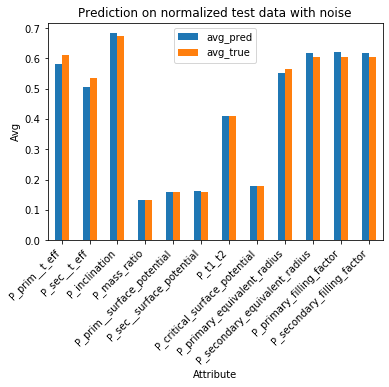

In [39]:
x = np.arange(len(n_eval_pred))
n_eval_pred[["avg_pred", "avg_true"]].plot(kind="bar")
plt.title("Prediction on normalized test data with noise")
plt.xlabel("Attribute")
plt.xticks(x, n_eval_pred.attribute, rotation=45, ha='right')
plt.ylabel("Avg")

### Denormalization

In [28]:
denormalized_n = scaler.inverse_transform(y_pred_norm_n)
denorm_n_pred = pd.DataFrame(denormalized_n,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])

In [29]:
n_pred_mean = denorm_n_pred.mean(axis=0)
n_pred_mean

P_prim__t_eff                    6428.259277
P_sec__t_eff                     6147.047363
P_inclination                       1.230415
P_mass_ratio                        1.409003
P_prim__surface_potential           3.972551
P_sec__surface_potential            4.012877
P_t1_t2                             1.048027
P_critical_surface_potential        4.322657
P_primary_equivalent_radius         0.427266
P_secondary_equivalent_radius       0.451965
P_primary_filling_factor            0.630932
P_secondary_filling_factor          0.629711
dtype: float32

In [30]:
y_test_n_denorm = scaler.inverse_transform(y_test_norm_n)
y_test_df = pd.DataFrame(y_test_n_denorm,
                            columns = [
                                "P_prim__t_eff",
                                "P_sec__t_eff",
                                "P_inclination",
                                "P_mass_ratio",
                                "P_prim__surface_potential",
                                "P_sec__surface_potential",
                                "P_t1_t2",
                                "P_critical_surface_potential",
                                "P_primary_equivalent_radius",
                                "P_secondary_equivalent_radius",
                                "P_primary_filling_factor",
                                "P_secondary_filling_factor"
                            ])
y_test_df.head()

,P_prim__t_eff,P_sec__t_eff,P_inclination,P_mass_ratio,P_prim__surface_potential,P_sec__surface_potential,P_t1_t2,P_critical_surface_potential,P_primary_equivalent_radius,P_secondary_equivalent_radius,P_primary_filling_factor,P_secondary_filling_factor
0,7000.0,6750.0,0.935491,3.333333,7.007351,7.007351,1.037037,7.054097,0.284784,0.492100,0.074968,0.074968
1,7000.0,6750.0,0.935491,3.333333,7.007351,7.007351,1.037037,7.054097,0.284784,0.492100,0.074968,0.074968
2,7000.0,6750.0,0.935491,3.333333,7.007351,7.007351,1.037037,7.054097,0.284784,0.492100,0.074968,0.074968
3,5750.0,5750.0,0.927295,2.500000,5.854167,5.854167,1.000000,5.945240,0.312934,0.471755,0.149309,0.149309
4,5750.0,5750.0,0.927295,2.500000,5.854167,5.854167,1.000000,5.945240,0.312934,0.471755,0.149309,0.149309


In [31]:
true_n_mean = y_test_df.mean(axis=0)
true_n_mean

P_prim__t_eff                    6542.375000
P_sec__t_eff                     6252.187500
P_inclination                       1.221348
P_mass_ratio                        1.412813
P_prim__surface_potential           3.972770
P_sec__surface_potential            3.972770
P_t1_t2                             1.048076
P_critical_surface_potential        4.286547
P_primary_equivalent_radius         0.431312
P_secondary_equivalent_radius       0.446961
P_primary_filling_factor            0.615457
P_secondary_filling_factor          0.615457
dtype: float64

In [32]:
eval_pred = pd.DataFrame({'attribute': true_n_mean.index,
            'avg_true': true_n_mean.values,
            'avg_pred': n_pred_mean.values,
            'MAE': abs(true_n_mean.values - n_pred_mean.values)})
eval_pred

,attribute,avg_true,avg_pred,MAE
0,P_prim__t_eff,6542.375000,6428.259277,114.115723
1,P_sec__t_eff,6252.187500,6147.047363,105.140137
2,P_inclination,1.221348,1.230415,0.009067
3,P_mass_ratio,1.412813,1.409003,0.003810
4,P_prim__surface_potential,3.972770,3.972551,0.000219
5,P_sec__surface_potential,3.972770,4.012877,0.040107
6,P_t1_t2,1.048076,1.048027,0.000049
7,P_critical_surface_potential,4.286547,4.322657,0.036110
8,P_primary_equivalent_radius,0.431312,0.427266,0.004047
9,P_secondary_equivalent_radius,0.446961,0.451965,0.005004
